# Comparing SODA an WOA datasets
for model validation

# <span style='color:Green'> SODA 3.4.2

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [21]:
client.close()
cluster.close()

In [14]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import gsw
from xhistogram.xarray import histogram
import fastjmd95 
from fastjmd95 import jmd95numba
import json

In [23]:
woa_8110 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_8110.nc')
woa_0517 = xr.open_dataarray('/home/jovyan/WMT-project/WOA/ts_hist_0517.nc')
#soda = xr.open_dataarray('/home/jovyan/WMT-project/SODA/ts_hist_mean_SODA.nc')
soda = xr.open_dataarray('/home/jovyan/WMT-project/SODA/ts_hist_mean_SODA_new.nc')

In [5]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)

In [15]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

cells = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr'))

/tmp/ipykernel_542/656088719.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  cells = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/cells_wg.zarr'))


In [6]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [7]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [8]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [9]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [10]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

In [11]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

In [12]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

In [16]:
#salt_bins = np.linspace(31.5, 35.5, 100)
#theta_bins = np.linspace(-2, 4, 100)
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = cells.dx_interp * cells.dy_u * cells.dz

In [18]:
ts_hist = histogram(ds_wg.temp, ds_wg.salt, 
                    bins=[theta_bins, salt_bins],
                    weights=vol, 
                    dim=['xt_ocean', 'yt_ocean', 'st_ocean']).rename({'temp_bin':'theta_bin', 
                                                                      'salt_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist.load()

<xarray.DataArray 'histogram_temp_salt' (time: 1970, theta_bin: 99, salt_bin: 99)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time       (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [19]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

In [20]:
ts_hist_mean

<xarray.DataArray 'histogram_temp_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [21]:
ts_hist_mean.load()

<xarray.DataArray 'histogram_temp_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [22]:
ts_hist_mean.to_netcdf('ts_hist_mean_SODA_new.nc', mode='w')

# <span style='background :yellow'> Difference between SODA and WOA (1981-2010) </span>

##### diff between old soda and new soda (with avd'g values for spikes in dates 1993

In [25]:
diff_soda_woa8110 = soda - woa_8110
diff_soda_woa8110

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

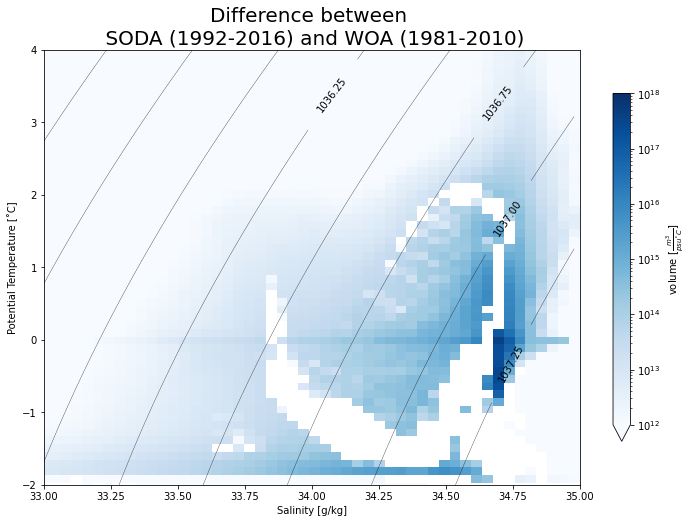

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.where(diff_soda_woa8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

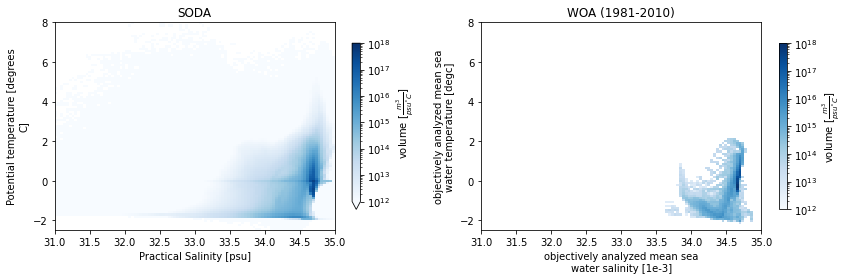

In [24]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

soda.where(soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SODA')

woa_8110.where(woa_8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (1981-2010)')

plt.tight_layout();

In [25]:
diff_soda_woa8110 = soda - woa_8110
diff_soda_woa8110

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [26]:
sigma2 = jmd95numba.rho(diff_soda_woa8110.salt_bin, diff_soda_woa8110.theta_bin, 2000.)

In [29]:
sigma2

<xarray.DataArray 'salt_bin' (salt_bin: 99, theta_bin: 99)>
array([[1034.48446211, 1034.47686275, 1034.46911858, ..., 1033.15615741,
        1033.13654091, 1033.116816  ],
       [1034.51665196, 1034.50903907, 1034.50128143, ..., 1033.18726956,
        1033.1676439 , 1033.14790986],
       [1034.5488422 , 1034.54121579, 1034.53344467, ..., 1033.21838227,
        1033.19874744, 1033.17900428],
       ...,
       [1037.57657459, 1037.56768554, 1037.55865689, ..., 1036.14555665,
        1036.12506696, 1036.10447236],
       [1037.60880537, 1037.59990298, 1037.59086104, ..., 1036.17672527,
        1036.15622655, 1036.13562296],
       [1037.64103662, 1037.63212089, 1037.62306566, ..., 1036.2078945 ,
        1036.18738676, 1036.16677418]])
Coordinates:
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    standard_name:  sea_water_salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10. 100.]

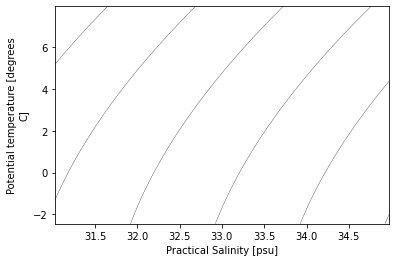

In [30]:
sigma2.transpose().plot.contour(colors='k', linewidths=0.3);

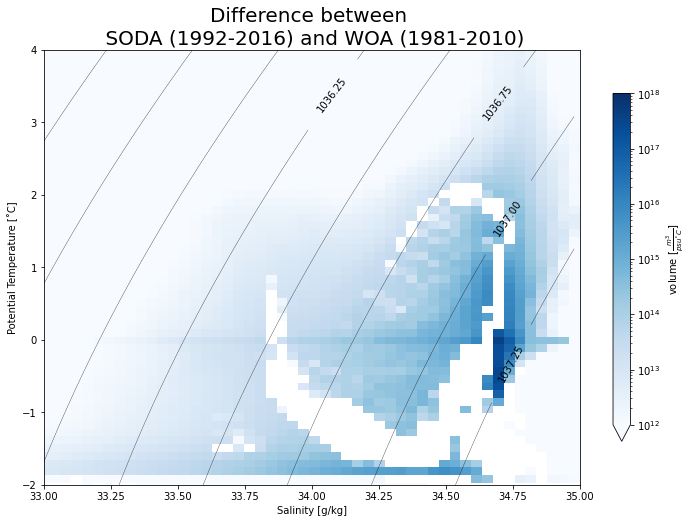

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.where(diff_soda_woa8110>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

## <span style='color:Purple'> Linear Scale

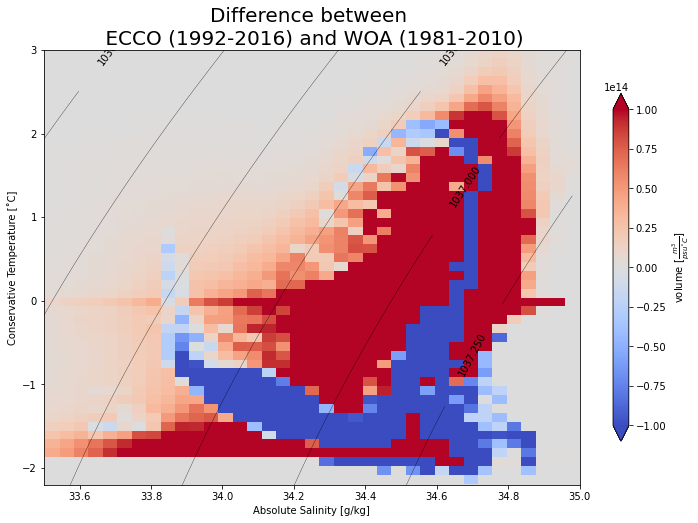

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.plot(cmap='coolwarm', vmax=1e14,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

<ipython-input-33-fadce3a97437>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  diff_soda_woa8110.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,


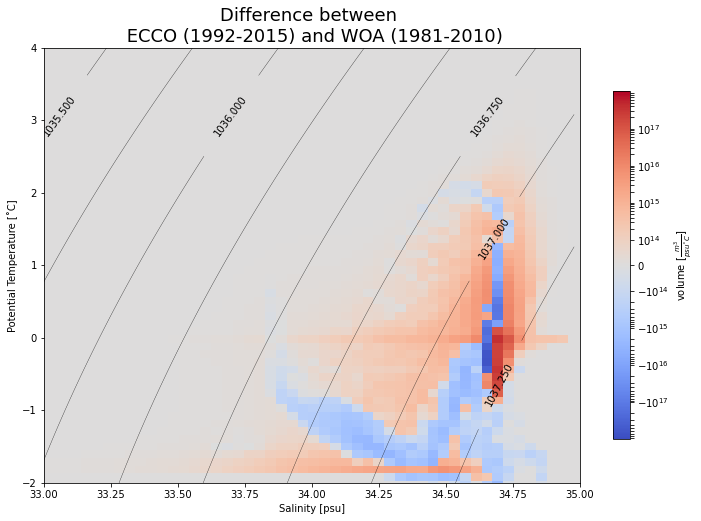

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa8110.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2015) and WOA (1981-2010)', fontsize=18);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

<ipython-input-34-451b5107f67e>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  (diff_soda_woa8110/woa_8110).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,


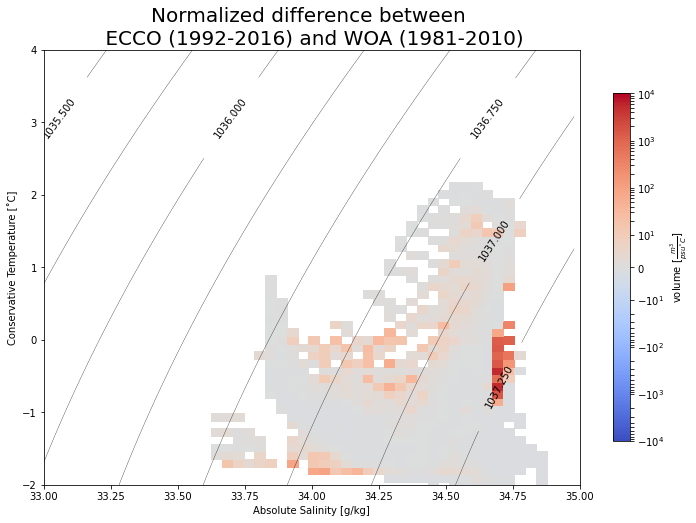

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
(diff_soda_woa8110/woa_8110).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
#got 0.4e18 from Linear Scale plot
#blue is positive
#red is negative

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (1981-2010)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

# <span style='background :yellow'> Difference between SODA and WOA (2005-2017)

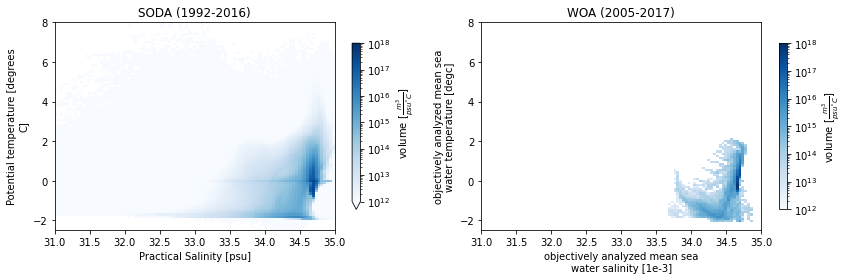

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

soda.where(soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SODA (1992-2016)')

woa_0517.where(woa_0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (2005-2017)')

plt.tight_layout();

In [37]:
diff_soda_woa0517 = soda - woa_0517
diff_soda_woa0517

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

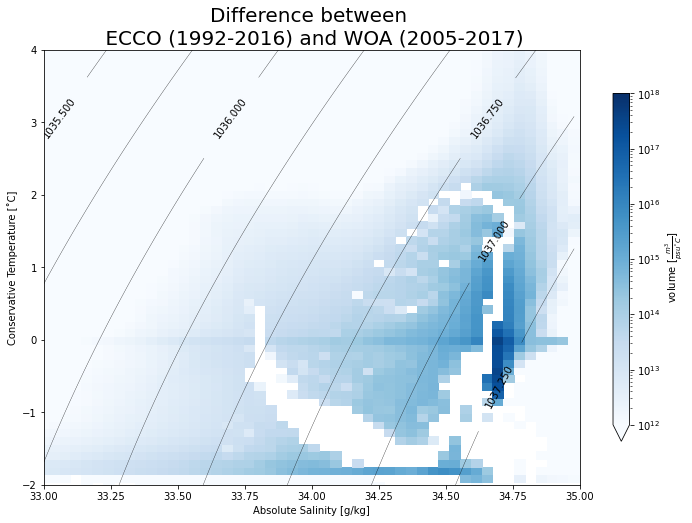

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.where(diff_soda_woa0517>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

## <span style='color:Purple'> Linear Scale

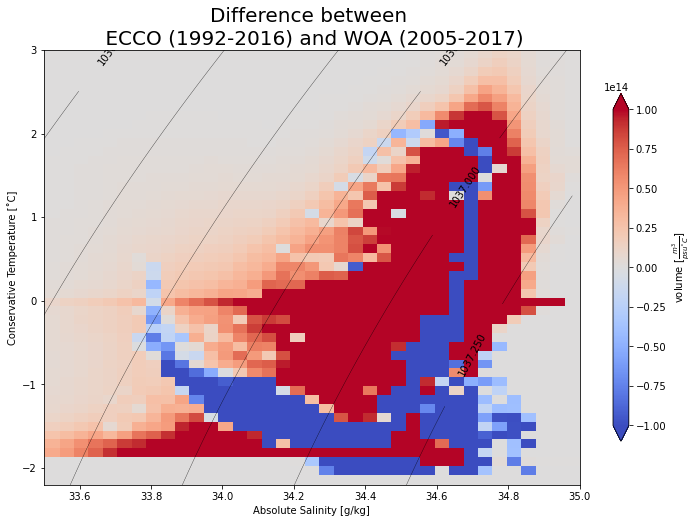

In [39]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.plot(cmap='coolwarm', vmax=1e14, cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 3);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

<ipython-input-40-c86c91b82a14>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  diff_soda_woa0517.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,


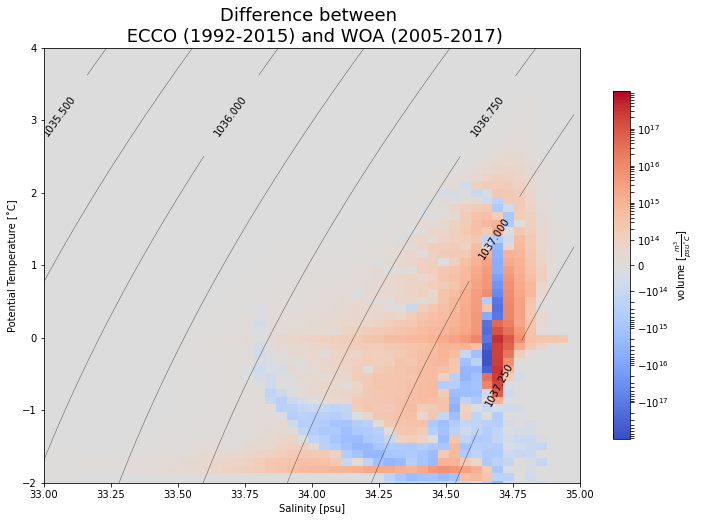

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0517.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n ECCO (1992-2015) and WOA (2005-2017)', fontsize=18);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);

<ipython-input-41-6bfd35a54832>:7: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  (diff_soda_woa0517/woa_0517).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,


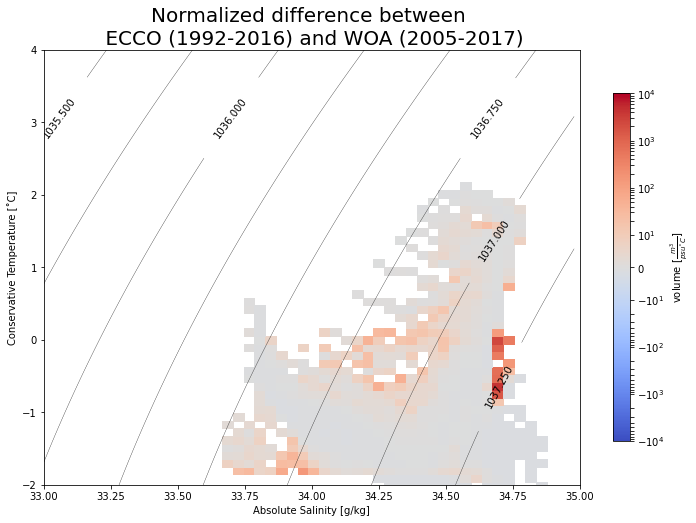

In [41]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
(diff_soda_woa0517/woa_0517).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n ECCO (1992-2016) and WOA (2005-2017)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 4);